In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [37]:
train = pd.read_csv('../../data/train_ship_segmentations_v2.csv')
train.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [38]:
train.shape

(231723, 2)

## Sample images with ships

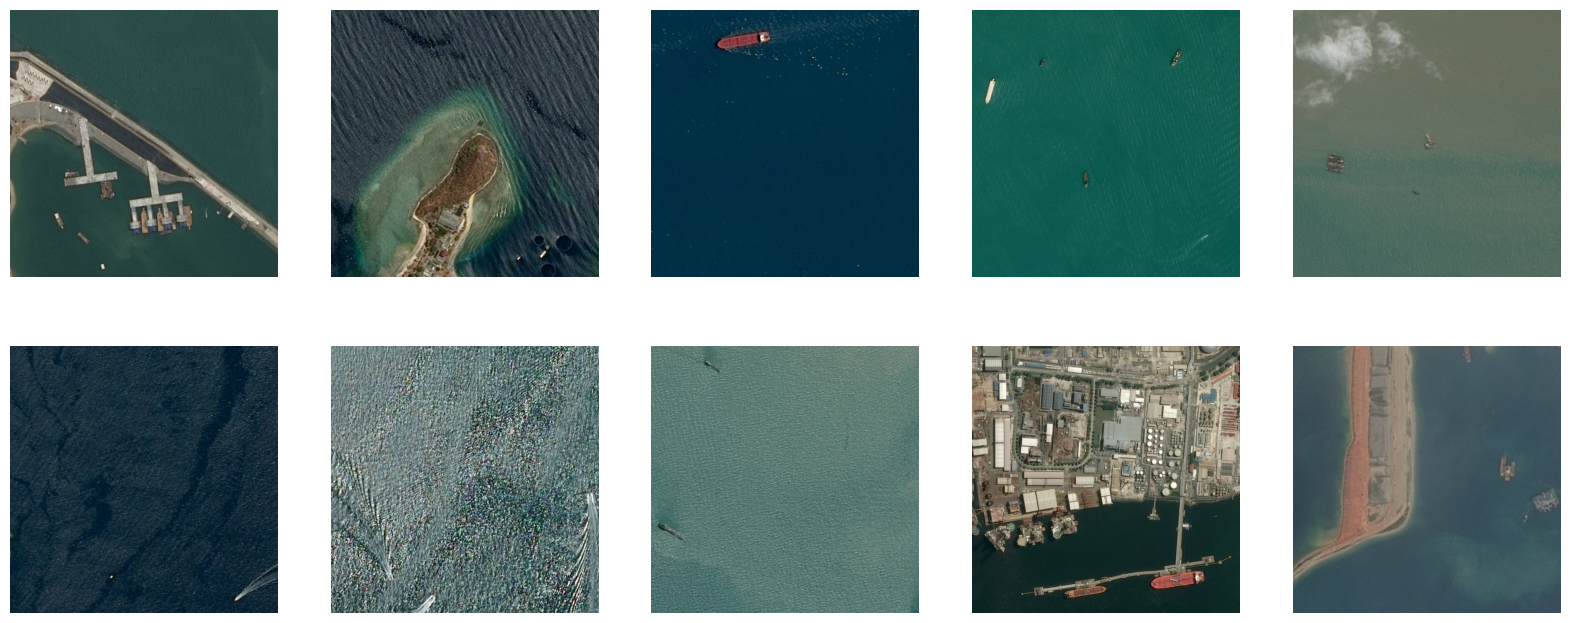

In [39]:
figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
sample = train[~train.EncodedPixels.isna()].sample(10)

for item in zip(axes.ravel(), sample.ImageId):
    ax, num = item
    img = mpimg.imread('../../data/train_v2/{}'.format(num))
    ax.imshow(img)
    ax.axis('off')

## Show masks

In [40]:
def apply_mask(image, mask):
    for x, y in mask:
        image[x, y, [0, 1]] = 255
    return image

In [41]:
sample

ImageId                                      EncodedPixels
67386   4aa1c99c5.jpg  29571 2 30337 4 31103 7 31871 7 32640 7 33408 ...
18479   147185598.jpg  406219 1 406986 3 407753 5 408520 7 409287 10 ...
97031   6b0343667.jpg  142935 4 143703 10 144471 17 145239 23 146006 ...
168977  ba729cfcc.jpg  26382 2 27146 6 27910 11 28675 14 29439 18 302...
27987   1f179c54d.jpg  69582 4 70343 11 71107 15 71875 15 72643 16 73...
113581  7d39b7415.jpg  493021 1 493787 4 494554 5 495320 8 496087 10 ...
170879  bcadbc7bd.jpg  131227 2 131995 5 132762 8 133530 11 134297 14...
137645  97e7672af.jpg  15115 1 15881 4 16647 6 17413 9 18179 11 18946...
123331  882bf7f0e.jpg      482053 2 482821 6 483588 10 484359 7 485131 3
109374  7873fdc34.jpg  374791 3 375559 7 376326 13 377094 17 377862 2...

In [42]:
def rle_to_pixels(rle_code):
    '''
    Transforms a RLE code string into a list of pixels of a (768, 768) canvas
    '''
    # Divide the rle in a list of pairs of ints rapresenring the (start,lenght)
    rle_code = [int(i) for i in rle_code.split()] 
    
    pixels = [
        #Find the 2d coordinate for the canva using the mod function (%) and the integer division function(//)
        (pixel_position % 768, pixel_position // 768) 
        # I select the start pixel and the lenght of the line
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2])) 
        # I screen all the pixel positions rapresenting (start,end)
                 for pixel_position in range(start, start + length)] 
    return pixels

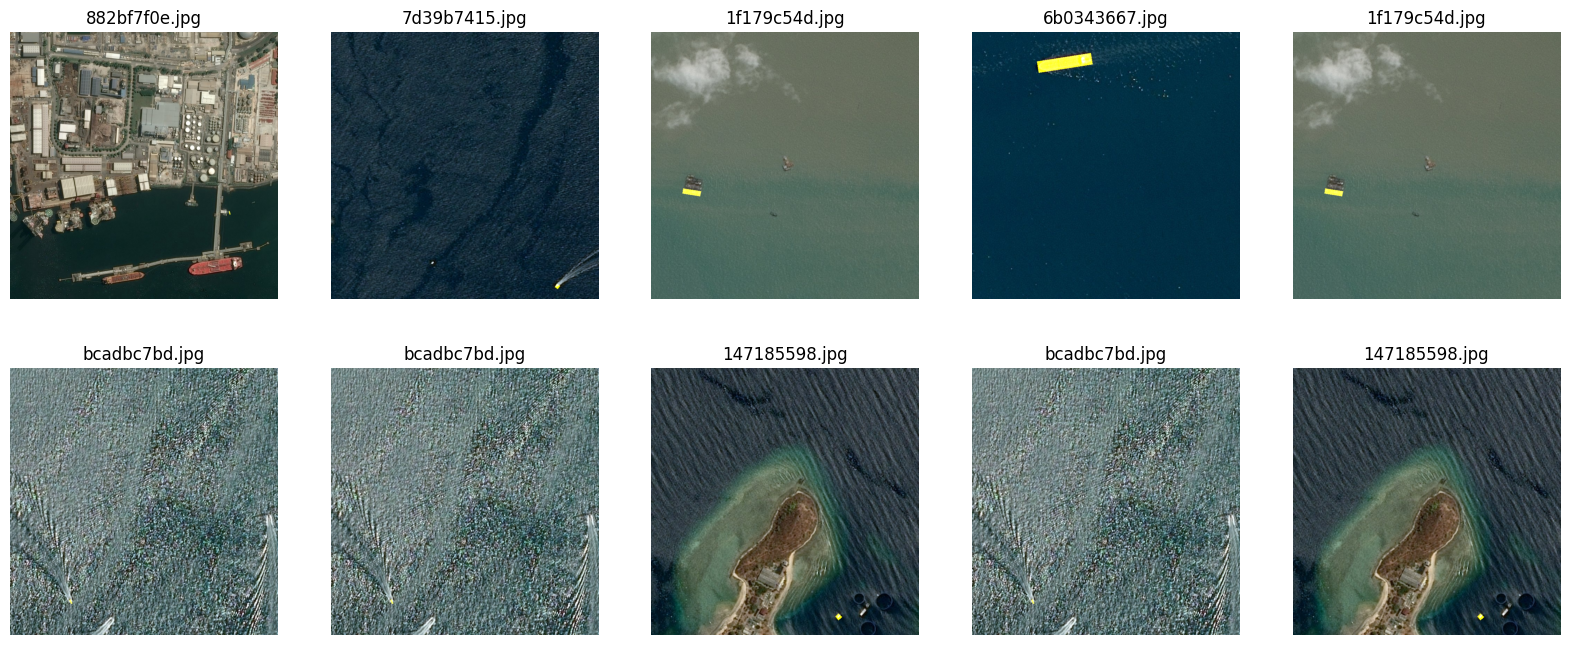

In [43]:
import PIL

sample = sample.groupby("ImageId")[['EncodedPixels']].agg(lambda rle_codes: ' '.join(rle_codes)).reset_index()
load_img = lambda filename: np.array(PIL.Image.open(f"../../data/train_v2/{filename}"))

_, axes_list = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

for axes in axes_list:
    for ax in axes:
        ax.axis('off')
        row_index = np.random.randint(len(sample)) # take a random row from the df
        ax.imshow(apply_mask(load_img(sample.loc[row_index, 'ImageId']), rle_to_pixels(sample.loc[row_index, 'EncodedPixels'])))
        ax.set_title(sample.loc[row_index, 'ImageId'])

## Sample images without ships

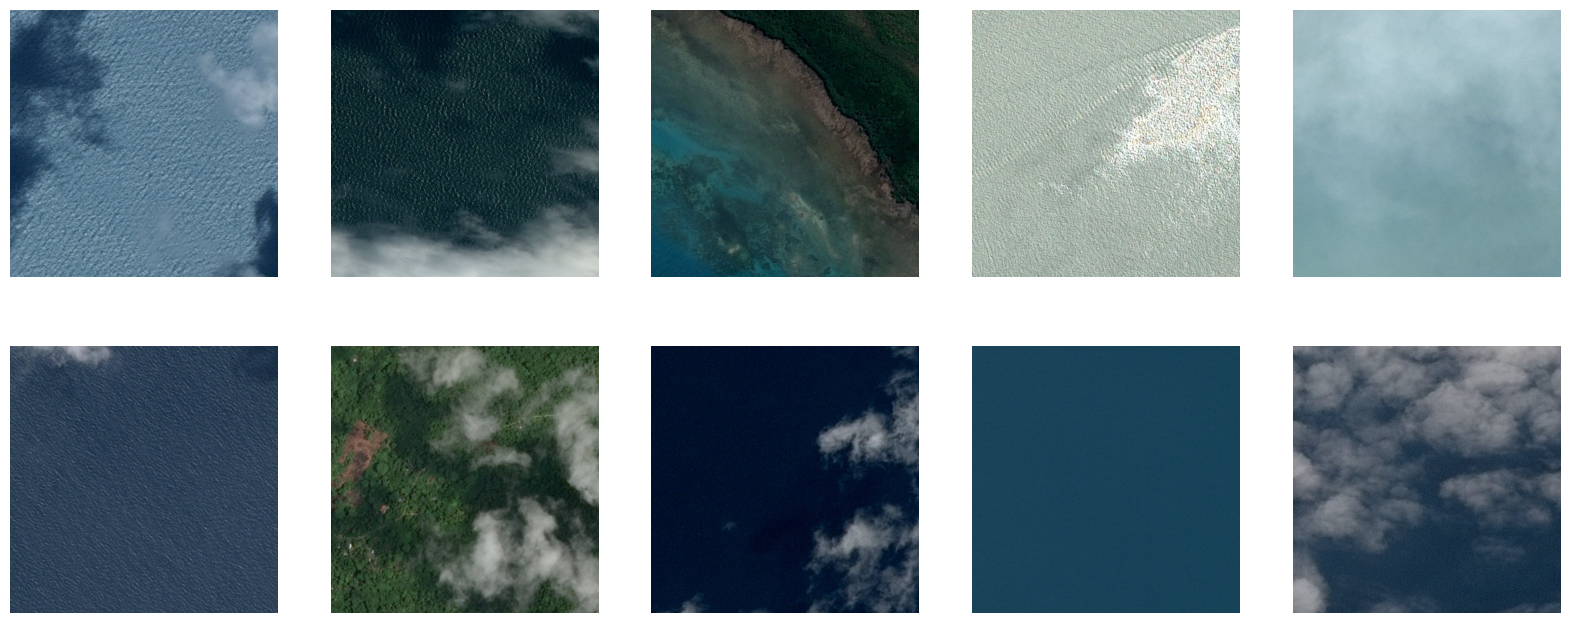

In [44]:
figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
sample = train[train.EncodedPixels.isna()].sample(10)

for item in zip(axes.ravel(), sample.ImageId):
    ax, num = item
    img = mpimg.imread('../../data/train_v2/{}'.format(num))
    ax.imshow(img)
    ax.axis('off')

## Class balance

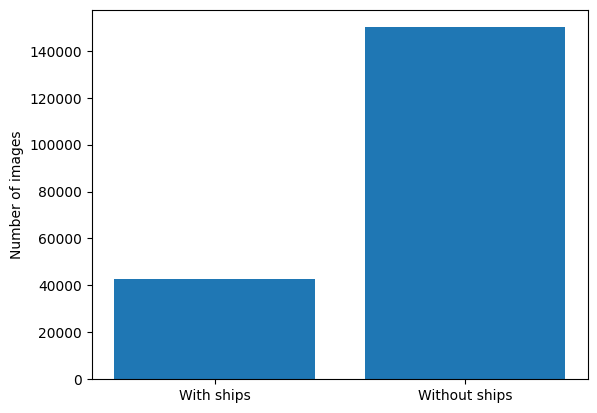

In [45]:
ships = train[~train.EncodedPixels.isna()].ImageId.unique()
noships = train[train.EncodedPixels.isna()].ImageId.unique()

plt.bar(['With ships', 'Without ships'], [len(ships), len(noships)])
plt.ylabel('Number of images')
plt.show()

## Distribution of objects on images with ships

In [46]:
ships = train.dropna().groupby('ImageId').count()
ships.describe()

EncodedPixels
count   42556.000000
mean        1.920364
std         1.906073
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        15.000000

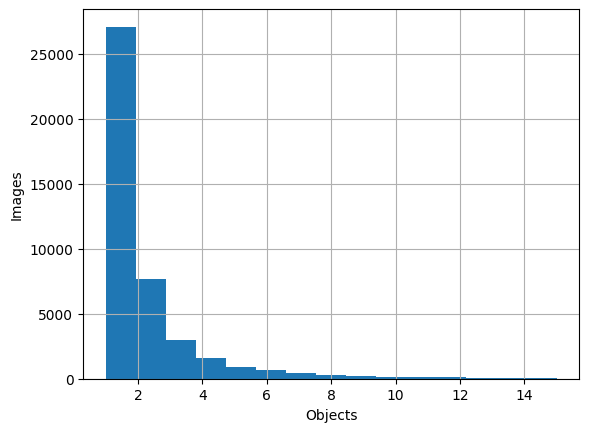

In [47]:
ships.EncodedPixels.hist(bins=15)
plt.xlabel('Objects')
plt.ylabel('Images')
plt.show()

## Color distribution

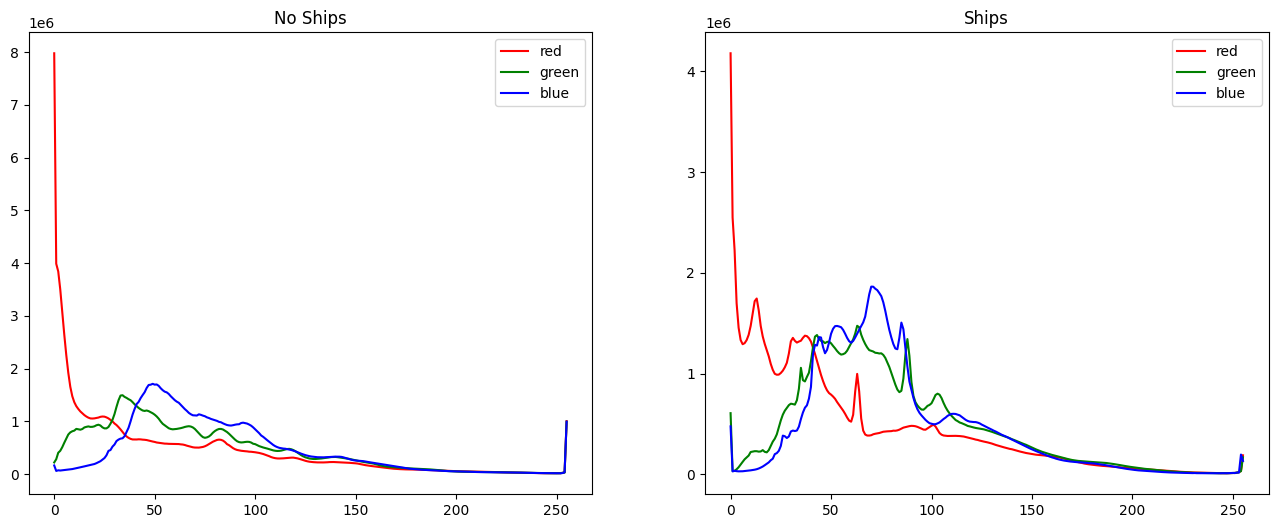

In [48]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

mask = train.EncodedPixels.isna()
for i, (msk, label) in enumerate(zip([mask, ~mask], ['No Ships', 'Ships'])):
    ids = train[msk].ImageId.sample(200)
    imgs = np.array([mpimg.imread('../../data/train_v2/{}'.format(i)) for i in ids])
    
    red = imgs[:, :, :, 0]
    green = imgs[:, :, :, 1]
    blue = imgs[:, :, :, 2]
    
    axes[i].plot(np.bincount(red.ravel()), color='red', label='red')
    axes[i].plot(np.bincount(green.ravel()), color='green', label='green')
    axes[i].plot(np.bincount(blue.ravel()), color='blue', label='blue')
    
    axes[i].legend()
    axes[i].title.set_text(label)